In [48]:
import os
import snirf
import datetime
import numpy as np
import pandas as pd

# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import firwin, lfilter
from typing import Union
from statistics import mean
from behav_analysis import Participant_Behav
from data_functions import Data_Functions, load_results


class Process_Flow:
    """
    This class contains functions for processing Kernel Flow data.
    Wrapper around an snirf.Snirf object.
    """

    def __init__(self, filepath: str) -> None:
        """
        Initialize by loading SNIRF file.

        Args:
            filepath (str): Path to SNIRF file.
        """
        self.data_fun = Data_Functions()
        self.snirf_file = self.load_snirf(filepath)

    def load_snirf(self, filepath: str) -> snirf.Snirf:
        """
        Load SNIRF file.

        Args:
            filepath (str): Path to SNIRF file.

        Returns:
            snirf.Snirf: SNIRF file object.
        """
        return snirf.Snirf(filepath, "r+", dynamic_loading=True)

    def get_time_origin(
        self, fmt: str = "datetime", offset=True
    ) -> Union[datetime.datetime, float]:
        """
        Get the time origin (start time) from the SNIRF file.

        Args:
            fmt (str, optional): Format to get the time origin in: "datetime" or "timestamp". Defaults to "datetime".
            offset (bool): Offset the datetime by 4 hours. Defaults to True.

        Raises:
            Exception: Invalid fmt argument.

        Returns:
            Union[datetime.datetime, float]:
                datetime.datetime: Time origin datetime.
                -or-
                float: Time origin timestamp.
        """
        start_date = self.snirf_file.nirs[0].metaDataTags.MeasurementDate
        start_time = self.snirf_file.nirs[0].metaDataTags.MeasurementTime
        start_str = start_date + " " + start_time
        if offset:
            time_origin = datetime.datetime.strptime(
                start_str, "%Y-%m-%d %H:%M:%S"
            ) - datetime.timedelta(
                hours=4
            )  # 4 hour offset
        else:
            time_origin = datetime.datetime.strptime(start_str, "%Y-%m-%d %H:%M:%S")
        if fmt.lower() == "datetime":
            return time_origin
        elif fmt.lower() == "timestamp":
            return datetime.datetime.timestamp(time_origin)
        else:
            raise Exception(
                "Invalid 'fmt' argument. Must be 'datetime' or 'timestamp'."
            )

    def get_subject_ID(self) -> str:
        """
        Get the subject ID from the SNIRF file.

        Returns:
            str: Subject ID.
        """
        return self.snirf_file.nirs[0].metaDataTags.SubjectID

    def get_time_rel(self) -> np.ndarray:
        """
        Get the relative time array from the SNIRF file.

        Returns:
            np.ndarray: Relative time array.
        """
        return self.snirf_file.nirs[0].data[0].time

    def get_time_abs(self, fmt: str = "datetime") -> np.ndarray:
        """
        Convert relative time array into an absolute time array.

        Args:
            fmt (str, optional): Format to get the time array in: "datetime" or "timestamp". Defaults to "datetime".

        Returns:
            np.ndarray: Absolute time array.
        """
        time_rel = self.get_time_rel()
        if fmt.lower() == "datetime":
            time_origin_dt = self.get_time_origin("datetime")
            return np.array(
                [
                    datetime.timedelta(seconds=time_rel[i]) + time_origin_dt
                    for i in range(len(time_rel))
                ]
            )
        elif fmt.lower() == "timestamp":
            time_origin_ts = self.get_time_origin("timestamp")
            return time_rel + time_origin_ts

    def get_data(
        self, fmt: str = "array", cols: list[int | list | tuple] = None
    ) -> Union[np.ndarray, pd.DataFrame]:
        """
        Get timeseries data from the SNIRF file.

        Args:
            fmt (str): Format of data (np.ndarray or pd.DataFrame). Defaults to "array".
            cols (list[int | list | tuple]): Data cols to select. Single col, list of cols, or slice of cols.
                                             Defaults to None (all columns).

        Raises:
            Exception: Invalid fmt argument.

        Returns:
            np.ndarray: Timeseries data array.
        """
        if cols or cols == 0:
            if isinstance(cols, tuple):
                data = (
                    self.snirf_file.nirs[0].data[0].dataTimeSeries[:, cols[0] : cols[1]]
                )
            else:
                data = self.snirf_file.nirs[0].data[0].dataTimeSeries[:, cols]
        else:
            data = self.snirf_file.nirs[0].data[0].dataTimeSeries

        if "array" in fmt.lower():
            return data
        elif "dataframe" in fmt.lower():
            return pd.DataFrame(data)
        else:
            raise Exception("Invalid fmt argument. Must be 'array' or 'dataframe'.")

    def get_source_pos_2d(self) -> np.ndarray:
        """
        Get the 2D source position array.

        Returns:
            np.ndarray: 2D source position array.
        """
        return self.snirf_file.nirs[0].probe.sourcePos2D

    def get_source_pos_3d(self) -> np.ndarray:
        """
        Get the 3D source position array.

        Returns:
            np.ndarray: 3D source position array.
        """
        return self.snirf_file.nirs[0].probe.sourcePos3D

    def get_detector_pos_2d(self) -> np.ndarray:
        """
        Get the 2D detector position array.

        Returns:
            np.ndarray: 2D detector position array.
        """
        return self.snirf_file.nirs[0].probe.detectorPos2D

    def get_detector_pos_3d(self) -> np.ndarray:
        """
        Get the 3D detector position array.

        Returns:
            np.ndarray: 3D detector position array.
        """
        return self.snirf_file.nirs[0].probe.detectorPos3D

    def get_measurement_list(self) -> np.array:
        """
        Get the data measurement list.

        Returns:
            np.array: Data measurement list array.
        """
        return self.snirf_file.nirs[0].data[0].measurementList

    def get_source_labels(self) -> np.array:
        """
        Get the source labels.

        Returns:
            np.array: Source label array.
        """
        return self.snirf_file.nirs[0].probe.sourceLabels

    def get_detector_labels(self) -> np.array:
        """
        Get the detector labels.

        Returns:
            np.array: Detector label array.
        """
        return self.snirf_file.nirs[0].probe.detectorLabels

    def get_marker_df(self) -> pd.DataFrame:
        """
        Get a DataFrame of marker data from the "stim" part of the SNIRF file.

        Returns:
            pd.DataFrame: Marker "stim" data.
        """
        marker_data = self.snirf_file.nirs[0].stim[0].data
        marker_data_cols = self.snirf_file.nirs[0].stim[0].dataLabels
        return pd.DataFrame(marker_data, columns=marker_data_cols)

    def get_unique_data_types(self) -> list:
        """
        Get unique data types from the SNIRF file.

        Returns:
            list: Unique data types.
        """
        data_types = []
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            data_type = self.snirf_file.nirs[0].data[0].measurementList[i].dataType
            if data_type not in data_types:
                data_types.append(data_type)
        return data_types

    def get_data_type_label(self, channel_num: int) -> str:
        """
        Get the data type label for a channel(s).

        Args:
            channel_num (int): Channel number to get the data type label of.

        Returns:
            str: Data type label of the channel.
        """
        return (
            self.snirf_file.nirs[0].data[0].measurementList[channel_num].dataTypeLabel
        )

    def get_unique_data_type_labels(self) -> list:
        """
        Get unique data type labels from the SNIRF file.

        Returns:
            list: Unique data type labels.
        """
        data_type_labels = []
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            data_type_label = (
                self.snirf_file.nirs[0].data[0].measurementList[i].dataTypeLabel
            )
            if data_type_label not in data_type_labels:
                data_type_labels.append(data_type_label)
        return data_type_labels

    def create_source_dict(self) -> dict:
        """
        Count the occurrences of each source index.

        Returns:
            dict: Counts for each source index.
        """
        source_dict = {}
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            source = self.snirf_file.nirs[0].data[0].measurementList[i].sourceIndex
            source_dict[source] = source_dict.get(source, 0) + 1
        source_dict = self.data_fun.sort_dict(source_dict, "keys")
        return source_dict

    def create_detector_dict(self) -> dict:
        """
        Count the occurrences of each detector index.

        Returns:
            dict: Counts for each detector index.
        """
        detector_dict = {}
        for i in range(len(self.snirf_file.nirs[0].data[0].measurementList)):
            detector = self.snirf_file.nirs[0].data[0].measurementList[i].detectorIndex
            detector_dict[detector] = detector_dict.get(detector, 0) + 1
        detector_dict = self.data_fun.sort_dict(detector_dict, "keys")
        return detector_dict

    def create_measurement_list_df(self) -> pd.DataFrame:
        """
        Create a DataFrame with all the data measurement list information.

        Returns:
            pd.DataFrame: Data measurement list DataFrame.
        """
        measurement_list = self.get_measurement_list()
        dict_list = []

        for i in range(len(measurement_list)):
            measurement_list_i = measurement_list[i]
            measurement_dict = {}
            measurement_dict["measurement_list_index"] = i + 1
            measurement_dict["data_type"] = measurement_list_i.dataType
            measurement_dict["data_type_index"] = measurement_list_i.dataTypeLabel
            measurement_dict["detector_index"] = measurement_list_i.detectorIndex
            measurement_dict["source_index"] = measurement_list_i.sourceIndex
            dict_list.append(measurement_dict)

        measurement_list_df = pd.DataFrame(dict_list)
        return measurement_list_df

    def create_source_df(self, dim: str) -> pd.DataFrame:
        """
        Create a DataFrame with the source labels and 2D or 3D source positions.

        Args:
            dim (str): Position data dimension "2D" or "3D".

        Returns:
            pd.DataFrame: Source labels and positions.
        """
        source_labels = self.get_source_labels()
        if dim.lower() == "2d":
            source_pos_2d = self.get_source_pos_2d()
            source_data = [
                (label, *lst) for label, lst in zip(source_labels, source_pos_2d)
            ]
            source_df = pd.DataFrame(
                source_data, columns=["source_label", "source_x_pos", "source_y_pos"]
            )
        elif dim.lower() == "3d":
            source_pos_3d = self.get_source_pos_3d()
            source_data = [
                (label, *lst) for label, lst in zip(source_labels, source_pos_3d)
            ]
            source_df = pd.DataFrame(
                source_data,
                columns=[
                    "source_label",
                    "source_x_pos",
                    "source_y_pos",
                    "source_pos_z",
                ],
            )
        # NOTE: Kernel changed source and detector label formats after a certain date
        try:
            f = lambda x: int(x.lstrip("S"))
            source_df.insert(1, "source_index", source_df["source_label"].apply(f))
        except ValueError:  # Format changed for participants 12+
            f = lambda x: int(x[1:4].lstrip("0"))
            source_df.insert(1, "source_index", source_df["source_label"].apply(f))
        return source_df

    def create_detector_df(self, dim: str) -> pd.DataFrame:
        """
        Create a DataFrame with the detector labels and 2D or 3D detector positions.

        Args:
            dim (str): Position data dimension "2D" or "3D".

        Returns:
            pd.DataFrame: Detector labels and positions.
        """
        detector_labels = self.get_detector_labels()
        if dim.lower() == "2d":
            detector_pos_2d = self.get_detector_pos_2d()
            detector_data = [
                (label, *lst) for label, lst in zip(detector_labels, detector_pos_2d)
            ]
            detector_df = pd.DataFrame(
                detector_data,
                columns=["detector_label", "detector_x_pos", "detector_y_pos"],
            )
        elif dim.lower() == "3d":
            detector_pos_3d = self.get_detector_pos_3d()
            detector_data = [
                (label, *lst) for label, lst in zip(detector_labels, detector_pos_3d)
            ]
            detector_df = pd.DataFrame(
                detector_data,
                columns=[
                    "detector_label",
                    "detector_x_pos",
                    "detector_y_pos",
                    "detector_pos_z",
                ],
            )
        # NOTE: Kernel changed source and detector label formats after a certain date
        if len(detector_df["detector_label"][0]) == 5:
            f = lambda x: int(x[1:3])
        elif (
            len(detector_df["detector_label"][0]) == 7
        ):  # Format changed for participants 12+
            f = lambda x: int(x[2:4])
        detector_df.insert(1, "source_index", detector_df["detector_label"].apply(f))
        detector_df.insert(1, "detector_index", range(1, detector_df.shape[0] + 1))
        return detector_df

    def create_source_detector_df(self) -> pd.DataFrame:
        """
        Create a DataFrame with the source and detector information for the inter-module channels.

        Returns:
            pd.DataFrame: Source and detector information for inter-module channels.
        """
        measurement_list_df = self.create_measurement_list_df()
        source_df = self.create_source_df("3D")
        detector_df = self.create_detector_df("3D")
        source_merge = pd.merge(measurement_list_df, source_df, on="source_index")
        merged_source_detector_df = pd.merge(
            source_merge, detector_df, on=["detector_index", "source_index"]
        )
        source_detector_df = merged_source_detector_df.copy()
        source_detector_df.insert(
            0, "channel_num", source_detector_df["measurement_list_index"] - 1
        )
        return source_detector_df

    def plot_pos(self, dim: str) -> None:
        """
        Plot the detector/source 2D or 3D positions.

        Args:
            dim (str): Position data dimension "2D" or "3D".
        """
        if dim.lower() == "2d":
            detector_pos_2d = self.get_detector_pos_2d()
            x_detector = detector_pos_2d[:, 0]
            y_detector = detector_pos_2d[:, 1]

            source_pos_2d = self.get_source_pos_2d()
            x_source = source_pos_2d[:, 0]
            y_source = source_pos_2d[:, 1]

            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(x_detector, y_detector)
            ax.scatter(x_source, y_source)
            ax.set_title("Detector/Source 2D Plot")
            ax.set_xlabel("X-Position (mm)")
            ax.set_ylabel("Y-Position (mm)")
            ax.legend(["Detector", "Source"])

        elif dim.lower() == "3d":
            detector_pos_3d = self.get_detector_pos_3d()
            x_detector = detector_pos_3d[:, 0]
            y_detector = detector_pos_3d[:, 1]
            z_detector = detector_pos_3d[:, 2]

            source_pos_3d = self.get_source_pos_3d()
            x_source = source_pos_3d[:, 0]
            y_source = source_pos_3d[:, 1]
            z_source = source_pos_3d[:, 2]

            fig = plt.figure()
            ax = fig.add_subplot(111, projection="3d")
            ax.scatter(x_detector, y_detector, z_detector)
            ax.scatter(x_source, y_source, z_source)
            ax.set_title("Detector/Source 3D Plot")
            ax.set_xlabel("X-Position (mm)")
            ax.set_ylabel("Y-Position (mm)")
            ax.set_zlabel("Z-Position (mm)")
            ax.legend(["Detector", "Source"])


class Participant_Flow:
    """
    This class contains functions, data structures, and info necessary for
    processing Kernel Flow data from the experiments.
    """

    def __init__(self, par_num):
        self.data_fun = Data_Functions()
        self.adj_ts_markers = True
        self.par_behav = Participant_Behav(par_num, self.adj_ts_markers)
        self.par_num, self.par_ID = self.data_fun.process_par(par_num)
        self.flow_raw_data_dir = os.path.join(
            self.par_behav.raw_data_dir, self.par_ID, "kernel_data"
        )
        self.flow_processed_data_dir = os.path.join(
            os.getcwd(), "processed_data", "flow"
        )
        self.flow_session_dict = self.create_flow_session_dict(wrapper=True)
        self.time_offset_dict = self.create_time_offset_dict()
        self.plot_color_dict = {
            0: "purple",
            1: "orange",
            2: "green",
            3: "yellow",
            4: "pink",
            5: "skyblue",
        }

    def calc_time_offset(self, exp_name: str) -> float:
        """
        Calculate the time offset (in seconds) between the behavioral and Kernel Flow data
        files. Number of seconds that the Kernel Flow data is ahead of the behavioral data.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            float: Time offset (in seconds).
        """
        exp = self.par_behav.get_exp(exp_name)
        exp_start_ts = exp.start_ts
        marker_sent_time = float(exp.marker_data["start_marker"]["sent_time"])
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        marker_df = self.create_abs_marker_df(session)
        row = marker_df.loc[marker_df["Marker"].str.startswith(exp_name)].reset_index()
        if (
            exp_name == "go_no_go"
        ):  # Go/No-go experiment is missing start timestamp marker
            try:
                kernel_start_ts = row.loc[0, "Start timestamp"]
                time_offset = kernel_start_ts - (exp_start_ts + marker_sent_time)
            except:
                time_offset = "NaN"
        else:
            kernel_start_ts = row.loc[0, "Start timestamp"]
            time_offset = kernel_start_ts - (exp_start_ts + marker_sent_time)
        return float(time_offset)

    def create_time_offset_dict(self) -> dict:
        """
        Create a dictionary containing the time offset (in seconds) for each experiment.

        Returns:
            dict: Time offset dictionary.
        """
        time_offset_dict = {}
        for exp_name in self.par_behav.exp_order:
            if (
                exp_name == "go_no_go"
            ):  # Go/No-go experiment is missing start timestamp marker
                if np.isnan(self.calc_time_offset(exp_name)):
                    session = self.par_behav.get_key_from_value(
                        self.par_behav.session_dict, exp_name
                    )
                    session_exp_names = self.par_behav.session_dict[session]
                    other_exp_names = [
                        temp_exp_name
                        for temp_exp_name in session_exp_names
                        if temp_exp_name != "go_no_go"
                    ]
                    other_exp_time_offsets = []
                    for temp_exp_name in other_exp_names:
                        time_offset = self.calc_time_offset(temp_exp_name)
                        other_exp_time_offsets.append(time_offset)
                    avg_time_offset = np.mean(other_exp_time_offsets)
                    time_offset_dict[exp_name] = avg_time_offset
            else:
                time_offset_dict[exp_name] = self.calc_time_offset(exp_name)
        for session, exp_list in self.par_behav.session_dict.items():
            session_offset = np.mean(
                [time_offset_dict[exp_name] for exp_name in exp_list]
            )
            time_offset_dict[session] = session_offset
        return time_offset_dict

    def get_time_offset(self, exp_name: str) -> float:
        """
        Get the time offset for an experiment.

        Args:
            exp_name (str): Experiment name.

        Returns:
            float: Time offset (in seconds).
        """
        return self.time_offset_dict[exp_name]

    def offset_time_array(self, exp_name: str, time_array: np.ndarray) -> np.ndarray:
        """
        Offset a Kernel Flow datetime array for an experiment by the time-offset.

        Args:
            exp_name (str): Name of the experiment.
            time_array (np.ndarray): Datetime array.

        Returns:
            np.ndarray: Time-offset datetime array.
        """
        try:
            time_offset = self.get_time_offset(exp_name)
        except KeyError:  # if experiment start time is missing, use avg of other session experiments
            time_offset_list = []
            for exp_name in self.par_behav.exp_order:
                try:
                    time_offset = self.get_time_offset(exp_name)
                    time_offset_list.append(time_offset)
                except KeyError:
                    pass
            time_offset = mean(time_offset_list)
        time_offset_dt = datetime.timedelta(seconds=time_offset)
        time_abs_dt_offset = time_array - time_offset_dt
        return time_abs_dt_offset

    def load_flow_session(
        self, session: list[str | int], wrapper: bool = False
    ) -> snirf.Snirf:
        """
        Load Kernel Flow data for an experiment session.

        Args:
            session list[str | int]: Experiment session.
            wrapper (bool, optional) Option to return Process_Flow-wrapped SNIRF file.
                                     Defaults to false.

        Raises:
            Exception: Invalid session number argument.

        Returns:
            snirf.Snirf: SNIRF file object.
            -or-
            Process_Flow object for each experiment session.
        """
        if isinstance(session, str):
            if "session" not in session:
                session = f"session_{session}"
        elif isinstance(session, int):
            session = f"session_{session}"
        try:
            session_dir = os.path.join(self.flow_raw_data_dir, session)
            filename = os.listdir(session_dir)[0]
            filepath = os.path.join(session_dir, filename)
            if wrapper:
                return Process_Flow(filepath)
            else:
                return Process_Flow(filepath).snirf_file
        except:
            print("Invalid session number.")
            raise

    def load_flow_exp(self, exp_name: str) -> pd.DataFrame:
        """
        Load Kernel Flow data for the time frame of a specified experiment.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            pd.DataFrame: Kernel Flow data for an experiment.
        """
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        flow_session = self.load_flow_session(session, wrapper=True)

        start_dt = self.par_behav.get_start_dt(exp_name, self.adj_ts_markers)
        end_dt = self.par_behav.get_end_dt(exp_name, self.adj_ts_markers)
        time_abs_dt = flow_session.get_time_abs("datetime")
        time_abs_dt_offset = self.offset_time_array(exp_name, time_abs_dt)
        start_idx = self.par_behav.get_start_index_dt(time_abs_dt_offset, start_dt)
        end_idx = self.par_behav.get_end_index_dt(time_abs_dt_offset, end_dt)

        flow_data = flow_session.get_data("dataframe")
        flow_data.insert(0, "datetime", time_abs_dt_offset)
        return flow_data.iloc[start_idx:end_idx, :]

    def create_flow_session_dict(self, wrapper: bool = False) -> dict:
        """
        Create a dictionary of Kernel Flow data for all experiment sessions.

        wrapper (bool, optional) Option to return Process_Flow-wrapped SNIRF file.
                                 Default to false.

        Returns:
            dict: Kernel Flow data for all experiment sessions.
                keys:
                    "session_1001", "session_1002", "session_1003"
                values:
                    SNIRF file object for each experiment session
                    -or-
                    Process_Flow object for each experiment session
        """
        flow_session_dict = {}
        for session in self.par_behav.session_dict.keys():
            flow_session_dict[session] = self.load_flow_session(session, wrapper)
        return flow_session_dict

    def create_abs_marker_df(self, session: str) -> pd.DataFrame:
        """
        Convert the "stim" marker DataFrame into absolute time.

        Args:
            session (str): Experiment session.

        Returns:
            pd.DataFrame: Marker "stim" data in absolute time.
        """
        marker_df = self.flow_session_dict[session].get_marker_df()
        time_origin_ts = self.flow_session_dict[session].get_time_origin("timestamp")
        marker_df["Timestamp"] = marker_df["Timestamp"] + time_origin_ts
        marker_df.rename({"Timestamp": "Start timestamp"}, axis=1, inplace=True)

        for idx, row in marker_df.iterrows():
            end_ts = row["Start timestamp"] + row["Duration"]
            marker_df.at[idx, "End timestamp"] = end_ts
            exp_num = int(row["Experiment"])
            exp_name = self.par_behav.marker_dict[exp_num]
            marker_df.at[idx, "Experiment"] = exp_name

        marker_df.rename({"Experiment": "Marker"}, axis=1, inplace=True)
        marker_df.drop(["Value"], axis=1, inplace=True)
        marker_df = marker_df[
            ["Marker", "Start timestamp", "Duration", "End timestamp"]
        ]
        return marker_df

    def create_exp_stim_response_dict(self, exp_name: str) -> dict:
        """
        Create a dictionary that contains the processed Kernel Flow data in response
        to a stimulus. It is organized by block (keys) and for each block, the value is
        a list of Pandas series. Each series is normalized, averaged, Kernel Flow data
        during a presented stimulus duration for each channel. Each block is baselined
        to the first 5 seconds, and the stim response is averaged over the stimulus
        presentation duration.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            dict:
                keys:
                    "block 1", "block 2", ... "block N"
                values:
                    dicts:
                        keys:
                            "trial 1", "trial 2", ... "trial N"
                        values:
                            lists of averaged, normalized Kernel Flow data series for each
                            channel during the stimulus duration
        """
        exp_results = load_results(
            self.par_behav.processed_data_dir, exp_name, self.par_behav.par_num
        )
        flow_exp = self.load_flow_exp(exp_name)
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        ts_list = self.flow_session_dict[session].get_time_abs("timestamp")
        exp_time_offset = self.time_offset_dict[exp_name]
        exp_by_block = self.par_behav.by_block_ts_dict[exp_name]

        blocks = list(exp_results["block"].unique())
        exp_stim_resp_dict = {
            block: {} for block in blocks
        }  # initialize with unique blocks
        processed_blocks = []

        if exp_name == "king_devick":  # normalize all blocks to the first block
            (first_block_start_ts, first_block_end_ts) = next(
                iter(exp_by_block.keys())
            )  # start/end of first block
            first_block_start_ts_offset = first_block_start_ts + exp_time_offset
            first_block_start_idx, _ = self.data_fun.find_closest_ts(
                first_block_start_ts_offset, ts_list
            )
            first_block_end_ts_offset = first_block_end_ts + exp_time_offset
            first_block_end_idx, _ = self.data_fun.find_closest_ts(
                first_block_end_ts_offset, ts_list
            )
            baseline_rows = flow_exp.loc[
                first_block_start_idx : first_block_start_idx + 35, 0:
            ]  # first 5 seconds of a block
            baseline = pd.DataFrame(baseline_rows.mean()).T

            for (
                block_start_ts,
                block_end_ts,
            ) in exp_by_block.keys():  # for each block in the experiment
                block_start_ts_offset = block_start_ts + exp_time_offset
                block_start_idx, _ = self.data_fun.find_closest_ts(
                    block_start_ts_offset, ts_list
                )
                block_end_ts_offset = block_end_ts + exp_time_offset
                block_end_idx, _ = self.data_fun.find_closest_ts(
                    block_end_ts_offset, ts_list
                )
                block_rows = flow_exp.loc[
                    block_start_idx:block_end_idx, 0:
                ]  # rows from block start to end

                baseline_df = pd.concat(
                    [baseline] * block_rows.shape[0], ignore_index=True
                )
                baseline_df = baseline_df.set_index(
                    pd.Index(range(block_start_idx, block_start_idx + len(baseline_df)))
                )

                block_rows_norm = block_rows.subtract(
                    baseline_df, fill_value=0
                )  # normalize the block rows
                processed_blocks.append(block_rows_norm)
        else:  # normalize each block to the start of the block
            for (
                block_start_ts,
                block_end_ts,
            ) in exp_by_block.keys():  # for each block in the experiment
                block_start_ts_offset = block_start_ts + exp_time_offset
                block_start_idx, _ = self.data_fun.find_closest_ts(
                    block_start_ts_offset, ts_list
                )
                block_end_ts_offset = block_end_ts + exp_time_offset
                block_end_idx, _ = self.data_fun.find_closest_ts(
                    block_end_ts_offset, ts_list
                )
                block_rows = flow_exp.loc[
                    block_start_idx:block_end_idx, 0:
                ]  # rows from block start to end

                baseline_rows = flow_exp.loc[
                    block_start_idx : block_start_idx + 35, 0:
                ]  # first 5 seconds of a block
                baseline = pd.DataFrame(baseline_rows.mean()).T
                baseline_df = pd.concat(
                    [baseline] * block_rows.shape[0], ignore_index=True
                )
                baseline_df = baseline_df.set_index(
                    pd.Index(range(block_start_idx, block_start_idx + len(baseline_df)))
                )

                block_rows_norm = block_rows.subtract(
                    baseline_df, fill_value=0
                )  # normalize the block rows
                processed_blocks.append(block_rows_norm)

        processed_block_df = pd.concat(
            processed_blocks
        )  # all processed blocks for an experiment

        for _, row in exp_results.iterrows():
            stim_start_ts = row["stim_start"]
            stim_start_ts_offset = stim_start_ts + exp_time_offset
            start_idx, _ = self.data_fun.find_closest_ts(stim_start_ts_offset, ts_list)
            stim_end_ts = row["stim_end"]
            stim_end_ts_offset = stim_end_ts + exp_time_offset
            end_idx, _ = self.data_fun.find_closest_ts(stim_end_ts_offset, ts_list)

            stim_rows = processed_block_df.loc[start_idx:end_idx, 0:]
            avg_stim_rows = stim_rows.mean()  # all channels for a stim

            block = row["block"]
            trial = row["trial"]

            if trial not in exp_stim_resp_dict[block].keys():
                exp_stim_resp_dict[block][trial] = []
            exp_stim_resp_dict[block][trial].append(
                avg_stim_rows
            )  # add to a block in dict

        return exp_stim_resp_dict

    def create_exp_stim_response_df(self, exp_name: str) -> pd.DataFrame:
        """
        Create a DataFrame that contains the processed Kernel Flow data in response
        to each stimulus in an experiment. Each channel is normalized and averaged.

        Args:
            exp_name (str): Name of the experiment.

        Returns:
            pd.DataFrame: Processed Kernel Flow data.
        """

        def _split_col(row: pd.Series) -> pd.Series:
            """
            Split a column containing an array into separate columns for each
            element in the array.

            Args:
                row (pd.Series): DataFrame row.

            Returns:
                pd.Series: DataFrame row with split column.
            """
            arr = row["Channels"]
            num_elements = len(arr)
            col_names = [i for i in range(num_elements)]
            return pd.Series(arr, index=col_names)

        exp_baseline_avg_dict = self.create_exp_stim_response_dict(exp_name)
        rows = []
        for block, block_data in sorted(exp_baseline_avg_dict.items()):
            for trial, stim_resp_data in block_data.items():
                trial_avg = np.mean(stim_resp_data, axis=0)
                row = {
                    "Participant": self.par_num,
                    "Block": block,
                    "Channels": trial_avg,
                }
                rows.append(row)

        stim_resp_df = pd.DataFrame(rows)
        channel_cols = stim_resp_df.apply(_split_col, axis=1)
        stim_resp_df = pd.concat(
            [stim_resp_df, channel_cols], axis=1
        )  # merge with original DataFrame
        stim_resp_df = stim_resp_df.drop(
            "Channels", axis=1
        )  # drop the original "Channels" column
        return stim_resp_df

    def create_inter_module_exp_results_df(
        self, exp_name: str, fmt: str = None
    ) -> pd.DataFrame:
        """
        Create a DataFrame with the inter-module channels for an experiment.
        This DataFrame can include both HbO and HbR channels in alternating columns
        or just "HbO", "HbR", "HbTot", or "HbDiff" channels.

        Args:
            fmt (str, optional): "HbO", "HbR", "HbTot", or "HbDiff" channels.
                                 Defaults to None (all inter-module channels).

        Returns:
            pd.DataFrame: Inter-module channels for an experiment.
        """

        def _compute_df(fmt: str) -> pd.DataFrame:
            """
            Create the HbTot and HbDiff DataFrames.

            Args:
                fmt (str): "HbTot" or "HbDiff".

            Returns:
                pd.DataFrame: HbTot or HbDiff DataFrame.
            """
            HbO_df = inter_module_df.iloc[
                :, np.r_[0, 1, 2 : len(inter_module_df.columns) : 2]
            ]
            HbO_data_cols = HbO_df.iloc[:, 2:]
            HbR_df = inter_module_df.iloc[
                :, np.r_[0, 1, 3 : len(inter_module_df.columns) : 2]
            ]
            HbR_data_cols = HbR_df.iloc[:, 2:]
            cols_dict = {}
            for i, col_name in enumerate(HbO_data_cols.columns):
                if fmt.lower() == "hbtot":
                    cols_dict[col_name] = (
                        HbO_data_cols.iloc[:, i] + HbR_data_cols.iloc[:, i]
                    )
                elif fmt.lower() == "hbdiff":
                    cols_dict[col_name] = (
                        HbO_data_cols.iloc[:, i] - HbR_data_cols.iloc[:, i]
                    )
            df = pd.DataFrame(cols_dict)
            df.insert(0, "Block", HbO_df["Block"])
            df.insert(0, "Participant", HbO_df["Participant"])
            return df

        exp_results = load_results(self.flow_processed_data_dir, exp_name)
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        measurement_list_df = self.flow_session_dict[
            session
        ].create_source_detector_df()
        channels = (measurement_list_df["measurement_list_index"] - 1).tolist()
        cols_to_select = ["Participant", "Block"] + [str(chan) for chan in channels]
        inter_module_df = exp_results.loc[:, cols_to_select]
        if fmt:
            if fmt.lower() == "hbo":  # HbO
                HbO_df = inter_module_df.iloc[
                    :, np.r_[0, 1, 2 : len(inter_module_df.columns) : 2]
                ]
                return HbO_df
            elif fmt.lower() == "hbr":  # HbR
                HbR_df = inter_module_df.iloc[
                    :, np.r_[0, 1, 3 : len(inter_module_df.columns) : 2]
                ]
                return HbR_df
            elif fmt.lower() == "hbtot":  # HbTot
                HbTot_df = _compute_df(fmt)
                return HbTot_df
            elif fmt.lower() == "hbdiff":  # HbDiff
                HbDiff_df = _compute_df(fmt)
                return HbDiff_df
        else:
            return inter_module_df

    def lowpass_filter(
        self, data: list[np.ndarray | pd.DataFrame]
    ) -> Union[np.ndarray, pd.DataFrame]:
        """
        Lowpass filter input data.

        Args:
            data list([np.ndarray | pd.DataFrame]): Data to filter.

        Returns:
            np.ndarray: Lowpass filtered data.
            -or-
            pd.DataFrame: Lowpass filtered data.
        """
        order = 20  # filter order
        fs = 1.0  # sampling frequency (Hz)
        cutoff = 0.1  # cut-off frequency (Hz)
        nyq = 0.5 * fs  # nyquist
        taps = firwin(order + 1, cutoff / nyq)

        if type(data) == pd.DataFrame:
            data_out = data.apply(
                lambda x: lfilter(taps, 1.0, x)
            )  # apply lowpass filter
        else:
            data_out = lfilter(taps, 1.0, data)  # apply lowpass filter
        return data_out

    def plot_flow_session(
        self, session: str, channels: list[int | list | tuple], filter_type: str = None
    ) -> None:
        """
        Plot Kernel flow session data.

        Args:
            session (str): Session number.
            channels (list[int | list | tuple]): Kernel Flow channels to plot.
            filter_type (str, optional): Filter type to apply. Defaults to None.
        """
        flow_session = self.flow_session_dict[session]
        sel_flow_data = flow_session.get_data("dataframe", channels)  # TODO
        if filter_type == "lowpass":
            sel_flow_data = self.lowpass_filter(sel_flow_data)
        session_time_offset = self.time_offset_dict[session]
        time_abs_dt = flow_session.get_time_abs("datetime")
        time_abs_dt_offset = time_abs_dt - datetime.timedelta(
            seconds=session_time_offset
        )
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))

        data_traces = []
        data_labels = []
        for channel_num in channels:
            flow_data = sel_flow_data.iloc[:, channel_num]
            data_type_label = self.flow_session_dict[session].get_data_type_label(
                channel_num
            )
            legend_label = f"Ch {channel_num} ({data_type_label})"
            if data_type_label == "HbO":
                color = "red"
            elif data_type_label == "HbR":
                color = "blue"
            (data_trace,) = ax.plot(
                time_abs_dt_offset, flow_data, color=color, label=legend_label
            )
            data_traces.append(data_trace)
            data_labels.append(legend_label)

        exp_spans = []
        for exp_name in self.par_behav.session_dict[session]:
            exp_start_dt = self.par_behav.get_start_dt(exp_name)
            exp_end_dt = self.par_behav.get_end_dt(exp_name)
            ax.axvline(exp_start_dt, linestyle="dashed", color="k", alpha=0.75)
            ax.axvline(exp_end_dt, linestyle="dashed", color="k", alpha=0.75)
            exp_span = ax.axvspan(
                exp_start_dt,
                exp_end_dt,
                color=self.par_behav.exp_color_dict[exp_name],
                alpha=0.4,
                label=exp_name,
            )
            exp_spans.append(exp_span)

        data_legend = ax.legend(
            handles=data_traces,
            bbox_to_anchor=(1.0, 1.0),
            facecolor="white",
            framealpha=1,
            title="Kernel Flow Data",
        )
        handles, labels = plt.gca().get_legend_handles_labels()
        uni_labels = dict(zip(labels, handles))
        [uni_labels.pop(data_label) for data_label in data_labels]

        stim_legend = ax.legend(
            uni_labels.values(),
            uni_labels.keys(),
            bbox_to_anchor=(1.0, 0.75),
            facecolor="white",
            framealpha=1,
            title="Experiment",
        )
        ax.add_artist(data_legend)
        session_split = session.split("_")
        exp_title = session_split[0].capitalize() + " " + session_split[1]
        ax.set_title(exp_title)
        datetime_fmt = mdates.DateFormatter("%H:%M:%S")
        ax.xaxis.set_major_formatter(datetime_fmt)
        ax.set_xlabel("Time", fontsize=16, color="k")

    def plot_flow_exp(
        self, exp_name: str, channels: list, filter_type: str = None
    ) -> None:
        """
        Plot Kernel Flow experiment data.

        Args:
            exp_name (str): Name of the experiment.
            channels (list): Kernel Flow channels to plot.
            filter_type (str, optional): Filter type to apply. Defaults to None.
        """
        flow_exp = self.load_flow_exp(exp_name)
        session = self.par_behav.get_key_from_value(
            self.par_behav.session_dict, exp_name
        )
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))

        data_traces = []
        data_labels = []
        for channel_num in channels:
            timeseries = flow_exp["datetime"]
            flow_data = flow_exp.iloc[:, channel_num + 1]
            if filter_type == "lowpass":
                flow_data = self.lowpass_filter(flow_data)
            data_type_label = self.flow_session_dict[session].get_data_type_label(
                channel_num
            )
            # legend_label = f"Ch {channel_num} ({data_type_label})"
            legend_label = f"{data_type_label}"
            if data_type_label == "HbO":
                color = "red"
            elif data_type_label == "HbR":
                color = "blue"
            (data_trace,) = ax.plot(
                timeseries, flow_data, color=color, label=legend_label
            )
            data_traces.append(data_trace)
            data_labels.append(legend_label)

        exp_start_dt = self.par_behav.get_start_dt(exp_name, self.adj_ts_markers)
        exp_end_dt = self.par_behav.get_end_dt(exp_name, self.adj_ts_markers)
        ax.axvline(exp_start_dt, linestyle="dashed", color="k", alpha=0.75)
        ax.axvline(exp_end_dt, linestyle="dashed", color="k", alpha=0.75)
        results_dir = r"C:\Users\zackg\OneDrive\Ayaz Lab\KernelFlow_Analysis\processed_data\behavioral"  # NOTE: temporary
        exp_results = load_results(results_dir, exp_name, self.par_num)
        exp_title = self.par_behav.format_exp_name(exp_name)

        stim_spans = []
        for _, row in exp_results.iterrows():
            try:
                uni_stim_dict = self.par_behav.create_unique_stim_dict(
                    exp_results, "stim"
                )
                stim = row["stim"]
                legend_label = self.par_behav.format_exp_name(row["stim"])
            except KeyError:
                uni_stim_dict = self.par_behav.create_unique_stim_dict(
                    exp_results, "block"
                )
                stim = row["block"]
                legend_label = self.par_behav.format_exp_name(row["block"])
            color_index = uni_stim_dict[stim]
            stim_start = datetime.datetime.fromtimestamp(row["stim_start"])
            try:
                stim_end = datetime.datetime.fromtimestamp(row["stim_end"])
            except ValueError:
                if exp_name == "go_no_go":
                    stim_time = 0.5  # seconds
                stim_end = datetime.datetime.fromtimestamp(
                    row["stim_start"] + stim_time
                )
            stim_span = ax.axvspan(
                stim_start,
                stim_end,
                color=self.plot_color_dict[color_index],
                alpha=0.4,
                label=legend_label,
            )
            stim_spans.append(stim_span)

        data_legend = ax.legend(
            handles=data_traces,
            bbox_to_anchor=(1.0, 1.0),
            facecolor="white",
            framealpha=1,
            title="fNIRS data",
        )
        handles, labels = plt.gca().get_legend_handles_labels()
        uni_labels = dict(zip(labels, handles))
        [uni_labels.pop(data_label) for data_label in data_labels]

        stim_legend = ax.legend(
            uni_labels.values(),
            uni_labels.keys(),
            bbox_to_anchor=(1.0, 0.75),
            facecolor="white",
            framealpha=1,
            title="Stimulus",
        )
        ax.add_artist(data_legend)
        ax.set_title(exp_title)
        datetime_fmt = mdates.DateFormatter("%H:%M:%S")
        ax.xaxis.set_major_formatter(datetime_fmt)
        ax.set_xlabel("Time", fontsize=16, color="k")
        ax.set_ylabel("Concentration (\u03bcM)", fontsize=16, color="k")
        # plt.savefig(r"C:\Users\zackg\Downloads\output.png", bbox_inches="tight")


def create_flow_results_tables(num_pars: int, inter_module_only=False) -> None:
    """
    Generate a CSV file that contains the Kernel Flow stimulus response data
    for all experiments and participants.

    Args:
        num_pars (int): Number of participants in the study.
        inter_module_only (bool): Select only inter-module channels. Defaults to False.
    """
    exp_names = [
        "audio_narrative",
        "go_no_go",
        "king_devick",
        "n_back",
        "resting_state",
        "tower_of_london",
        "vSAT",
        "video_narrative_cmiyc",
        "video_narrative_sherlock",
    ]
    hemo_types = ["HbO", "HbR", "HbTot", "HbDiff"]
    if inter_module_only:
        print(f"Processing participants ...")
        par = Participant_Flow(
            1
        )  # NOTE: inter-module DataFrame is computed for all participants
        for hemo_type in hemo_types:
            all_exp_results_list = []
            exp_results_list = []
            for exp_name in exp_names:
                stim_resp_df = par.create_inter_module_exp_results_df(
                    exp_name, hemo_type
                )
                exp_results_list.append(stim_resp_df)
            all_exp_results_list.append(exp_results_list)

            filedir = os.path.join(
                par.flow_processed_data_dir, "inter_module_channels", hemo_type
            )
            if not os.path.exists(filedir):
                os.makedirs(filedir)

            print(f"Creating {hemo_type} CSV files ...")
            all_exp_filepath = os.path.join(
                filedir, f"all_experiments_flow_{hemo_type}.csv"
            )
            if os.path.exists(all_exp_filepath):
                os.remove(all_exp_filepath)
            for i, exp_name in enumerate(exp_names):
                exp_rows = [
                    exp_results_list[i] for exp_results_list in all_exp_results_list
                ]
                exp_df = pd.concat(exp_rows, axis=0, ignore_index=True)
                filepath = os.path.join(filedir, f"{exp_name}_flow_{hemo_type}.csv")
                exp_df.to_csv(filepath, index=False)
                all_exp_df = exp_df.copy(deep=True)
                exp_name_col = [exp_name] * len(all_exp_df.index)
                all_exp_df.insert(0, "Experiment", exp_name_col)
                if i == 0:
                    all_exp_df.to_csv(
                        all_exp_filepath, mode="a", header=True, index=False
                    )
                else:
                    all_exp_df.to_csv(
                        all_exp_filepath, mode="a", header=False, index=False
                    )
    else:
        for par_num in range(1, num_pars + 1):
            print(f"Processing participant {par_num} ...")
            par = Participant_Flow(par_num)
            exp_results_list = []
            for exp_name in exp_names:
                stim_resp_df = par.create_exp_stim_response_df(exp_name)
                exp_results_list.append(stim_resp_df)
            all_exp_results_list.append(exp_results_list)

        filedir = os.path.join(par.flow_processed_data_dir, "all_channels")
        if not os.path.exists(filedir):
            os.makedirs(filedir)

        print("Creating CSV files ...")
        all_exp_filepath = os.path.join(filedir, f"all_experiments_flow.csv")
        if os.path.exists(all_exp_filepath):
            os.remove(all_exp_filepath)
        for i, exp_name in enumerate(exp_names):
            exp_rows = [
                exp_results_list[i] for exp_results_list in all_exp_results_list
            ]
            exp_df = pd.concat(exp_rows, axis=0, ignore_index=True)
            filepath = os.path.join(filedir, f"{exp_name}_flow.csv")
            exp_df.to_csv(filepath, index=False)
            all_exp_df = exp_df.copy(deep=True)
            exp_name_col = [exp_name] * len(all_exp_df.index)
            all_exp_df.insert(0, "Experiment", exp_name_col)
            if i == 0:
                all_exp_df.to_csv(all_exp_filepath, mode="a", header=True, index=False)
            else:
                all_exp_df.to_csv(all_exp_filepath, mode="a", header=False, index=False)


In [49]:
# SNIRF file loading
par_num = 12
par = Participant_Flow(par_num)
print(par.par_ID)
# par.plot_flow_exp("n_back", [0, 1], "lowpass")

participant_12


In [13]:
exp_names = [
    "audio_narrative",
    "go_no_go",
    "king_devick",
    "n_back",
    "resting_state",
    "tower_of_london",
    "vSAT",
    "video_narrative_cmiyc",
    "video_narrative_sherlock",
]
hemo_types = ["HbO", "HbR", "HbTot", "HbDiff"]

exp_name = "n_back"
hemo_type = hemo_types[0]
filedir = os.path.join(par.flow_processed_data_dir, "inter_module_channels", hemo_type)
filename = f"{exp_name}_flow_{hemo_type}.csv"
filepath = os.path.join(filedir, filename)
exp_results = load_results(filedir, exp_name)

def simulate_LMM(exp_name: str, hemo_type: str) -> tuple:
    filedir = os.path.join(par.flow_processed_data_dir, "inter_module_channels", hemo_type)
    exp_results = load_results(filedir, exp_name)
    # channel_data = exp_results.iloc[:, 2:]
    # do some LMM magic on exp_results ...
    global channel_num
    channel_num += 1
    condition = "0_back"
    p_value = round(np.random.uniform(0.001, 0.1), 3)
    F_value = round(np.random.uniform(10, 150), 3)
    df = int(np.random.uniform(10, 20))
    df1 = df - 5
    df2 = df + 5

    return (channel_num, condition, p_value, F_value, df1, df2)

results_dir = r"C:\Users\zackg\OneDrive\Ayaz Lab\KernelFlow_Analysis\results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

for hemo_type in hemo_types:
    print(f"Processing {hemo_type} data ...")
    exp_results_list = []
    for exp_name in exp_names:
        channel_num = -1
        num_chans = 306
        exp_results_dict = {}
        chan_num_list = []
        condition_list = []
        p_value_list = []
        F_value_list = []
        df1_list = []
        df2_list = []
        for i in range(num_chans):
            chan_num, condition, p_value, F_value, df1, df2 = simulate_LMM(exp_name, hemo_type)
            chan_num_list.append(chan_num)
            condition_list.append(condition)
            p_value_list.append(p_value)
            F_value_list.append(F_value)
            df1_list.append(df1)
            df2_list.append(df2)
            exp_name_list = [exp_name] * num_chans
            exp_results_dict["experiment"] = exp_name_list
            exp_results_dict["channel_num"] = chan_num_list
            exp_results_dict["condition"] = condition_list
            exp_results_dict["p_value"] = p_value_list
            exp_results_dict["F_value"] = F_value_list
            exp_results_dict["df1"] = df1_list
            exp_results_dict["df2"] = df2_list
        exp_results_df = pd.DataFrame(exp_results_dict)
        exp_results_list.append(exp_results_df)
    stat_results_df = pd.concat(exp_results_list, ignore_index=True)
    filename = f"flow_stats_{hemo_type}.csv"
    filepath = os.path.join(results_dir, filename)
    stat_results_df.to_csv(filepath, index=False)

Processing HbO data ...
Processing HbR data ...
Processing HbTot data ...
Processing HbDiff data ...


In [50]:
par_num = 12
par = Participant_Flow(par_num)
par.flow_session_dict["session_1001"].create_source_detector_df()

,channel_num,measurement_list_index,data_type,data_type_index,detector_index,source_index,source_label,source_x_pos,source_y_pos,source_pos_z,detector_label,detector_x_pos,detector_y_pos,detector_pos_z
0,0,1,99999,HbO,1,1,M001S00,-28.553709,84.555525,4.810424,M001D00,-19.532142,88.683819,4.546779
1,1,2,99999,HbR,1,1,M001S00,-28.553709,84.555525,4.810424,M001D00,-19.532142,88.683819,4.546779
2,2,3,99999,HbO,2,1,M001S00,-28.553709,84.555525,4.810424,M001D01,-24.939996,87.637162,-3.856334
3,3,4,99999,HbR,2,1,M001S00,-28.553709,84.555525,4.810424,M001D01,-24.939996,87.637162,-3.856334
4,4,5,99999,HbO,3,1,M001S00,-28.553709,84.555525,4.810424,M001D02,-34.199054,83.900605,-3.417358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,4287,4288,99999,HbR,304,51,M051S00,-56.993148,-99.328864,-13.652867,M051D03,-50.299321,-106.771940,-12.553116
608,4288,4289,99999,HbO,305,51,M051S00,-56.993148,-99.328864,-13.652867,M051D04,-55.194041,-103.103048,-4.592239
609,4289,4290,99999,HbR,305,51,M051S00,-56.993148,-99.328864,-13.652867,M051D04,-55.194041,-103.103048,-4.592239
610,4290,4291,99999,HbO,306,51,M051S00,-56.993148,-99.328864,-13.652867,M051D05,-62.262083,-96.103651,-5.817627


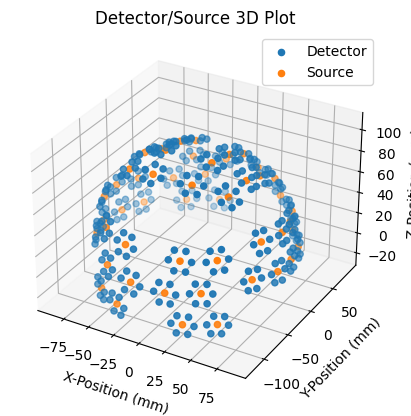

In [25]:
par.flow_session_dict["session_1001"].plot_pos("3d")
